In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher

# Load data using pandas
combined_df = pd.read_csv("CBikes-Data-04-10.csv")

# EDA
print(combined_df.info())
print(combined_df.head(5))

# Feature engineering
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])
combined_df['trip_duration'] = (combined_df['ended_at'] - combined_df['started_at']).dt.total_seconds() / 60
combined_df['day_of_month'] = combined_df['started_at'].dt.day
combined_df['hour_of_day'] = combined_df['started_at'].dt.hour

# Handle outliers
q1, q3 = combined_df['trip_duration'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr
combined_df = combined_df[(combined_df['trip_duration'] >= lower_bound) & (combined_df['trip_duration'] <= upper_bound)]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649653 entries, 0 to 649652
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             649653 non-null  object 
 1   rideable_type       649653 non-null  object 
 2   started_at          649653 non-null  object 
 3   ended_at            649653 non-null  object 
 4   start_station_name  649586 non-null  object 
 5   start_station_id    649586 non-null  object 
 6   end_station_name    647535 non-null  object 
 7   end_station_id      647535 non-null  object 
 8   start_lat           649653 non-null  float64
 9   start_lng           649653 non-null  float64
 10  end_lat             648949 non-null  float64
 11  end_lng             648949 non-null  float64
 12  member_casual       649653 non-null  object 
dtypes: float64(4), object(9)
memory usage: 64.4+ MB
None
            ride_id  rideable_type           started_at             ended_at  \
0

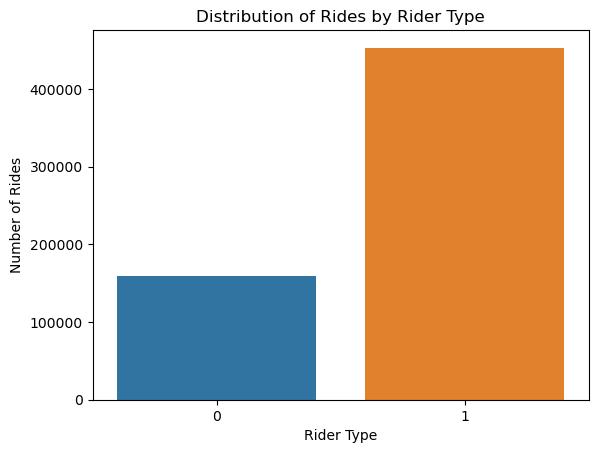

In [2]:

# Casual vs. Member Rider Type Analysis
label_encoder = LabelEncoder()
combined_df['member_casual'] = label_encoder.fit_transform(combined_df['member_casual'])

# Visualize distribution of rides
sns.countplot(data=combined_df, x='member_casual')
plt.xlabel('Rider Type')
plt.ylabel('Number of Rides')
plt.title('Distribution of Rides by Rider Type')
plt.show()

# Feature columns and target column
feature_columns = ["start_lng", "end_lng", "trip_duration", "day_of_month", "hour_of_day"]
target_column = "member_casual"



Logistic Regression Accuracy: 0.740322120285423
Random Forest Classifier Accuracy: 0.7485912334352701
Confusion Matrix:
[[ 1438 30237]
 [  592 90358]]
Classification Report:
              precision    recall  f1-score   support

      casual       0.71      0.05      0.09     31675
      member       0.75      0.99      0.85     90950

    accuracy                           0.75    122625
   macro avg       0.73      0.52      0.47    122625
weighted avg       0.74      0.75      0.66    122625



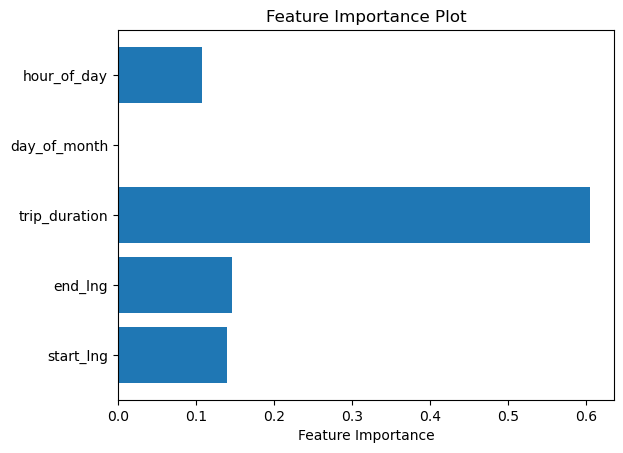

In [4]:
# Split data into training and test sets
X = combined_df[feature_columns]
y = combined_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# Handling Missing Values
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

# Handling Infinite Values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Classifier Accuracy: {rf_accuracy}")

# Confusion Matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:")
print(rf_conf_matrix)

# Classification Report for Random Forest
class_names = ['casual', 'member']
rf_classification_report = classification_report(y_test, rf_predictions, target_names=class_names)
print("Classification Report:")
print(rf_classification_report)

# Feature Importance for Random Forest
feature_importance = rf_classifier.feature_importances_
plt.barh(feature_columns, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()


Logistic Regression Accuracy: 0.740322120285423
Confusion Matrix for Logistic Regression:
[[ 2633 29042]
 [ 2801 88149]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      casual       0.48      0.08      0.14     31675
      member       0.75      0.97      0.85     90950

    accuracy                           0.74    122625
   macro avg       0.62      0.53      0.49    122625
weighted avg       0.68      0.74      0.66    122625



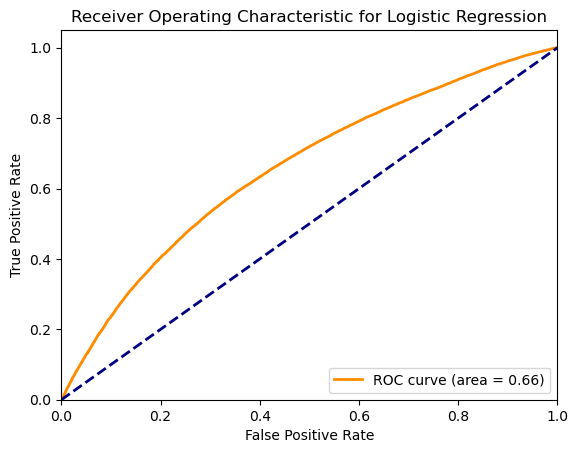

Random Forest Classifier Accuracy: 0.7485912334352701
Confusion Matrix for Random Forest:
[[ 1438 30237]
 [  592 90358]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

      casual       0.71      0.05      0.09     31675
      member       0.75      0.99      0.85     90950

    accuracy                           0.75    122625
   macro avg       0.73      0.52      0.47    122625
weighted avg       0.74      0.75      0.66    122625



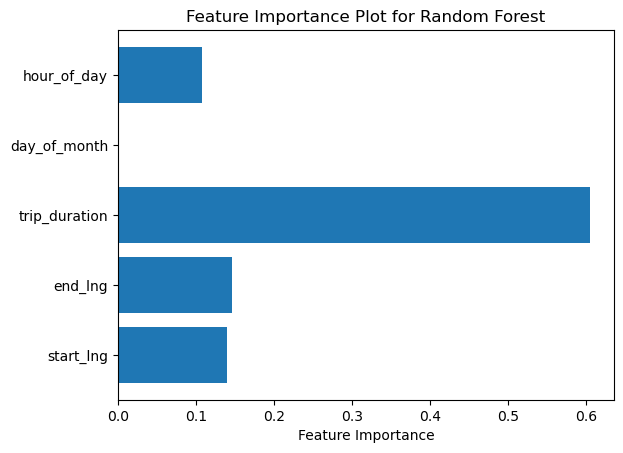

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Split data into training and test sets
X = combined_df[feature_columns]
y = combined_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Handling Missing Values
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

# Handling Infinite Values
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Confusion Matrix for Logistic Regression
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)
print("Confusion Matrix for Logistic Regression:")
print(lr_conf_matrix)

# Classification Report for Logistic Regression
lr_classification_report = classification_report(y_test, lr_predictions, target_names=class_names)
print("Classification Report for Logistic Regression:")
print(lr_classification_report)

# ROC Curve for Logistic Regression
lr_probabilities = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, lr_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Classifier Accuracy: {rf_accuracy}")

# Confusion Matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix for Random Forest:")
print(rf_conf_matrix)

# Classification Report for Random Forest
rf_classification_report = classification_report(y_test, rf_predictions, target_names=class_names)
print("Classification Report for Random Forest:")
print(rf_classification_report)

# Feature Importance for Random Forest
feature_importance = rf_classifier.feature_importances_
plt.barh(feature_columns, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot for Random Forest')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=123)

# Setup the grid search
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Start the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

best_params


Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [6]:
from sklearn.model_selection import GridSearchCV


# Hyperparameter Tuning for Random Forest Classifier
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

rf_classifier = RandomForestClassifier(random_state=123)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

# Create a Random Forest Classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=123)
best_rf_classifier.fit(X_train, y_train)

# Evaluate the model with the best hyperparameters
best_rf_predictions = best_rf_classifier.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, best_rf_predictions)
print(f"Random Forest Classifier Accuracy (Tuned): {best_rf_accuracy}")


KeyboardInterrupt: 